In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona


In [2]:
incidents = pd.read_csv('unique_fires.csv')
incidents = incidents[incidents['Fire Name']=='AUGUST COMPLEX'] #here we filter out August Complex
incidents # these are submitted in local time

inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
incidents

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire
1088,11843929.0,AUGUST COMPLEX,2020-08-17 13:44:00,2020-11-11,39.659444,-122.808889


In [4]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})
viirs_all

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,46.145030,-114.230690,301.50,0.40,0.60,2019-12-04,842,1,VIIRS,n,2.0NRT,266.30,1.30,N,NaN
1,42.689530,-111.592030,309.10,0.55,0.51,2019-12-04,842,1,VIIRS,n,2.0NRT,270.90,8.00,N,NaN
2,47.817650,-103.056590,296.60,0.42,0.38,2019-12-04,842,1,VIIRS,n,2.0NRT,269.20,0.60,N,NaN
3,45.846410,-105.521350,297.80,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,0.80,N,NaN
4,45.842090,-105.516050,306.40,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,2.20,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065362,39.142639,-121.509666,344.93,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,286.05,6.97,D,0.0
1065363,39.143078,-121.504829,328.83,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,284.42,4.39,D,0.0
1065364,38.063091,-121.160683,328.92,0.42,0.45,2020-12-31,2124,N,VIIRS,n,1,282.11,2.19,D,0.0
1065365,38.223763,-121.081375,325.87,0.42,0.46,2020-12-31,2124,N,VIIRS,n,1,280.99,2.84,D,0.0


In [5]:
#get the size of the resulting dataframe
df_size = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
print(df_size)

1339


In [12]:
fire_series = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of VIIRS points': np.nan*np.zeros(df_size), 
                                'FRP': np.nan*np.zeros(df_size),
            'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
count = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    lat_fire = incidents.iloc[ii]['Lat Fire']
    lon_fire = incidents.iloc[ii]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    poly_lats = np.array([lat_fire])
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
   
    for day in dates: #loop over the days
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        for over in overpasses: #loop over the overpasses
            print(day, over)
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
            
            
            mp, poly_lats, poly_lons = build_today_polygon(pt_start, lat, lon, lat_old, lon_old, 0.2, 0)
            
            num_viirs = len(poly_lats)
            print(num_viirs, 'VIIRS detections')
            if num_viirs==0: #if no points, persist the previous polygon
                poly = pt_start
                poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
            elif (num_viirs<=0.1*len(lat_old))|(num_viirs<=2): #if points drop off by >90% or to 2 or fewer
                #use old polygon, and ADD THE NEW POINTS, just in case
                lat_old = np.append(lat_old, poly_lats)
                lon_old = np.append(lon_old, poly_lons)
                poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
                poly = MultiPoint(poly_tups).convex_hull
                
            else: #make a new polygon 
                #print('HELLO!')
                old_poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))] #old polygon points
                poly_tups = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lats))] #new polygon points
                poly_tups = [item for item in poly_tups if item not in old_poly_tups] #get rid of duplicates                
                poly = MultiPoint(poly_tups).convex_hull
            
            
            inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups] #inds where we grab FRP
            if len(inds_new_points)==0:
                frp=np.nan
            else:
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])
            fire_series.iloc[count] = [incidents['Incident Number'].iloc[ii],\
                                       incidents['Fire Name'].iloc[ii],\
                                       day, over, lat_fire, lon_fire, num_viirs,\
                                      frp, poly]
            lat_old = [poly_tups[i][1] for i in range(len(poly_tups))]
            lon_old = [poly_tups[i][0] for i in range(len(poly_tups))]
            pt_start=poly
            count = count+1
                
            
fire_series

-122.8088889 39.6594444
2020-08-18 800
0 VIIRS detections
2020-08-18 806
0 VIIRS detections
2020-08-18 854
Time for recursive call
12 VIIRS detections
2020-08-18 900
0 VIIRS detections
2020-08-18 942
0 VIIRS detections
2020-08-18 948
Time for recursive call
43 VIIRS detections
2020-08-18 1036
14 VIIRS detections
2020-08-18 1124
0 VIIRS detections
2020-08-18 1836
0 VIIRS detections
2020-08-18 1842
0 VIIRS detections
2020-08-18 1924
0 VIIRS detections
2020-08-18 1930
0 VIIRS detections
2020-08-18 2018
Time for recursive call
61 VIIRS detections
2020-08-18 2106
43 VIIRS detections
2020-08-18 2112
0 VIIRS detections
2020-08-18 2200
24 VIIRS detections
2020-08-19 742
0 VIIRS detections
2020-08-19 748
0 VIIRS detections
2020-08-19 836
0 VIIRS detections
2020-08-19 842
0 VIIRS detections
2020-08-19 924
0 VIIRS detections
2020-08-19 930
Time for recursive call
947 VIIRS detections
2020-08-19 1012
0 VIIRS detections
2020-08-19 1018
Time for recursive call
1251 VIIRS detections
2020-08-19 1106
1

Time for recursive call
362 VIIRS detections
2020-08-31 906
0 VIIRS detections
2020-08-31 948
0 VIIRS detections
2020-08-31 954
Time for recursive call
785 VIIRS detections
2020-08-31 1042
279 VIIRS detections
2020-08-31 1930
0 VIIRS detections
2020-08-31 1936
0 VIIRS detections
2020-08-31 2024
247 VIIRS detections
2020-08-31 2112
Time for recursive call
566 VIIRS detections
2020-08-31 2118
48 VIIRS detections
2020-08-31 2206
257 VIIRS detections
2020-09-01 748
0 VIIRS detections
2020-09-01 754
0 VIIRS detections
2020-09-01 842
0 VIIRS detections
2020-09-01 930
0 VIIRS detections
2020-09-01 936
Time for recursive call
1071 VIIRS detections
2020-09-01 1018
0 VIIRS detections
2020-09-01 1024
935 VIIRS detections
2020-09-01 1112
527 VIIRS detections
2020-09-01 1824
0 VIIRS detections
2020-09-01 1912
0 VIIRS detections
2020-09-01 1918
0 VIIRS detections
2020-09-01 2006
316 VIIRS detections
2020-09-01 2054
Time for recursive call
646 VIIRS detections
2020-09-01 2100
0 VIIRS detections
2020-

251 VIIRS detections
2020-09-13 730
0 VIIRS detections
2020-09-13 812
0 VIIRS detections
2020-09-13 818
0 VIIRS detections
2020-09-13 906
Time for recursive call
463 VIIRS detections
2020-09-13 912
0 VIIRS detections
2020-09-13 954
0 VIIRS detections
2020-09-13 1000
Time for recursive call
877 VIIRS detections
2020-09-13 1048
639 VIIRS detections
2020-09-13 1848
0 VIIRS detections
2020-09-13 1854
0 VIIRS detections
2020-09-13 1936
0 VIIRS detections
2020-09-13 1942
0 VIIRS detections
2020-09-13 2030
470 VIIRS detections
2020-09-13 2036
0 VIIRS detections
2020-09-13 2118
Time for recursive call
693 VIIRS detections
2020-09-13 2124
0 VIIRS detections
2020-09-13 2212
337 VIIRS detections
2020-09-14 754
0 VIIRS detections
2020-09-14 800
0 VIIRS detections
2020-09-14 848
0 VIIRS detections
2020-09-14 854
0 VIIRS detections
2020-09-14 936
0 VIIRS detections
2020-09-14 942
Time for recursive call
1133 VIIRS detections
2020-09-14 1030
1087 VIIRS detections
2020-09-14 1118
0 VIIRS detections
20

Time for recursive call
268 VIIRS detections
2020-09-26 1054
92 VIIRS detections
2020-09-26 1854
0 VIIRS detections
2020-09-26 1900
0 VIIRS detections
2020-09-26 1942
0 VIIRS detections
2020-09-26 1948
0 VIIRS detections
2020-09-26 2036
18 VIIRS detections
2020-09-26 2124
0 VIIRS detections
2020-09-26 2130
0 VIIRS detections
2020-09-27 806
0 VIIRS detections
2020-09-27 854
Time for recursive call
44 VIIRS detections
2020-09-27 942
0 VIIRS detections
2020-09-27 948
Time for recursive call
205 VIIRS detections
2020-09-27 1036
127 VIIRS detections
2020-09-27 1924
0 VIIRS detections
2020-09-27 1930
0 VIIRS detections
2020-09-27 2012
0 VIIRS detections
2020-09-27 2018
Time for recursive call
Time for recursive call
Time for recursive call
Time for recursive call
342 VIIRS detections
2020-09-27 2106
Time for recursive call
530 VIIRS detections
2020-09-27 2112
0 VIIRS detections
2020-09-27 2200
506 VIIRS detections
2020-09-28 742
0 VIIRS detections
2020-09-28 748
0 VIIRS detections
2020-09-28

2020-10-10 806
0 VIIRS detections
2020-10-10 812
0 VIIRS detections
2020-10-10 900
0 VIIRS detections
2020-10-10 906
0 VIIRS detections
2020-10-10 948
0 VIIRS detections
2020-10-10 954
0 VIIRS detections
2020-10-10 1042
0 VIIRS detections
2020-10-10 1842
0 VIIRS detections
2020-10-10 1848
0 VIIRS detections
2020-10-10 1930
0 VIIRS detections
2020-10-10 1936
0 VIIRS detections
2020-10-10 2024
0 VIIRS detections
2020-10-10 2030
0 VIIRS detections
2020-10-10 2112
0 VIIRS detections
2020-10-10 2118
0 VIIRS detections
2020-10-10 2206
0 VIIRS detections
2020-10-11 748
0 VIIRS detections
2020-10-11 754
0 VIIRS detections
2020-10-11 842
0 VIIRS detections
2020-10-11 848
0 VIIRS detections
2020-10-11 930
2 VIIRS detections
2020-10-11 936
0 VIIRS detections
2020-10-11 1024
4 VIIRS detections
2020-10-11 1112
1 VIIRS detections
2020-10-11 1912
0 VIIRS detections
2020-10-11 1918
0 VIIRS detections
2020-10-11 2000
0 VIIRS detections
2020-10-11 2006
2 VIIRS detections
2020-10-11 2054
2 VIIRS detectio

0 VIIRS detections
2020-10-26 1042
0 VIIRS detections
2020-10-26 1930
0 VIIRS detections
2020-10-26 1936
0 VIIRS detections
2020-10-26 2024
0 VIIRS detections
2020-10-26 2030
0 VIIRS detections
2020-10-26 2112
0 VIIRS detections
2020-10-26 2118
0 VIIRS detections
2020-10-26 2206
0 VIIRS detections
2020-10-27 748
0 VIIRS detections
2020-10-27 842
0 VIIRS detections
2020-10-27 848
0 VIIRS detections
2020-10-27 930
0 VIIRS detections
2020-10-27 936
0 VIIRS detections
2020-10-27 1024
0 VIIRS detections
2020-10-27 1112
0 VIIRS detections
2020-10-27 1912
0 VIIRS detections
2020-10-27 1918
0 VIIRS detections
2020-10-27 2006
0 VIIRS detections
2020-10-27 2054
0 VIIRS detections
2020-10-27 2100
0 VIIRS detections
2020-10-27 2142
0 VIIRS detections
2020-10-27 2148
0 VIIRS detections
2020-10-28 736
0 VIIRS detections
2020-10-28 824
0 VIIRS detections
2020-10-28 912
0 VIIRS detections
2020-10-28 918
0 VIIRS detections
2020-10-28 1000
0 VIIRS detections
2020-10-28 1006
1 VIIRS detections
2020-10-28

,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of VIIRS points,FRP,geometry
0,11843929.0,AUGUST COMPLEX,2020-08-18,800.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
1,11843929.0,AUGUST COMPLEX,2020-08-18,806.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.76889 39.65944, -122.76908 39.6..."
2,11843929.0,AUGUST COMPLEX,2020-08-18,854.0,39.659444,-122.808889,12.0,41.89,"POLYGON ((-122.74513 39.59618, -122.75537 39.5..."
3,11843929.0,AUGUST COMPLEX,2020-08-18,900.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.74513 39.59618, -122.75537 39.5..."
4,11843929.0,AUGUST COMPLEX,2020-08-18,942.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.74513 39.59618, -122.75537 39.5..."
...,...,...,...,...,...,...,...,...,...
1334,11843929.0,AUGUST COMPLEX,2020-11-11,1936.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."
1335,11843929.0,AUGUST COMPLEX,2020-11-11,2024.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."
1336,11843929.0,AUGUST COMPLEX,2020-11-11,2112.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."
1337,11843929.0,AUGUST COMPLEX,2020-11-11,2118.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-123.08621 40.24213, -123.15018 40.2..."


In [13]:
hi = fire_series['geometry']
hi
therest = fire_series[['Incident Number', 'Fire Name', 'Current Day','Current Overpass','Lat Fire', 'Lon Fire','Number of VIIRS points', 'FRP']]
therest

fiona.supported_drivers
hi.to_file("august_complex_polygons_only.geojson", driver='GeoJSON')
therest.to_csv('august_complex_polygons_attributes.csv')

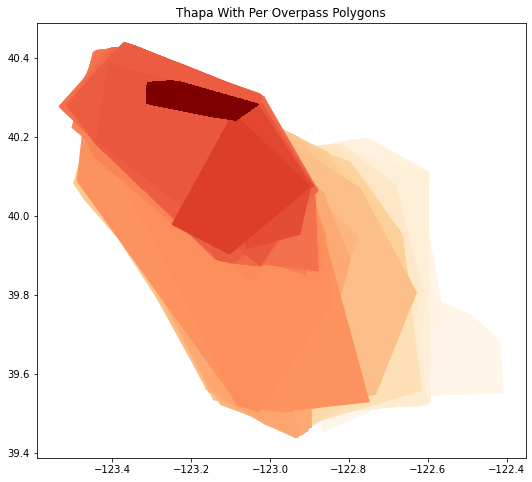

In [14]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
fire_series.plot(column = fire_series['Current Day'], ax=ax, cmap='OrRd')
plt.title('Thapa With Per Overpass Polygons')
plt.show()

In [11]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(shape, lats, lons, lat_old, lon_old, bf, plot_evol):
    shape_buff = shape.buffer(bf)
    
    #find the points that are inside the buffer
    lat_new = np.nan*np.zeros(len(lats))
    lon_new = np.nan*np.zeros(len(lons))
    i = 0
    for pair in zip(lons, lats):
        pt_check = Point(pair)
        if shape_buff.contains(pt_check):
            #add the point to the list
            lat_new[i] = pair[1]
            lon_new[i] = pair[0]
            i = i+1
    #grab the new points
    lat_new = lat_new[np.where(~np.isnan(lat_new))]
    lon_new = lon_new[np.where(~np.isnan(lon_new))]
    #make a shape around them
    tups = [list((lon_new[i], lat_new[i])) for i in range(len(lat_new))]
    mp = MultiPoint(tups).convex_hull
    
    if plot_evol == 1: #plot the new polygon
        print(len(lat_new), len(lon_new))
        m = gpd.GeoSeries(mp)
        m.plot()
        plt.scatter(lon_new, lat_new, c = 'k')
        plt.scatter(lon_fire, lat_fire, c='r')
        plt.title('Updated shape and points')
        plt.show()
    
    if (len(lat_new)-len(lat_old))>0: #if we are adding points
        print('Time for recursive call')
        return build_today_polygon(mp, lats, lons, lat_new, lon_new, bf, plot_evol)
    else:
        return mp, lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON